## Quantum algorithm for a chemical reaction path optimization by using a variational quantum algorithm and a reaction path generation

<h5>Author: GC Team<h5>
<h5>Last updated: 28 February 2023.<h5>



In the research and development of new materials, the chemical reaction calculation has a wide range of applications. And the key step of chemical reaction calculation is obtaining the activation energy which is an important indicator in chemical reaction, which refers to the energy required for a molecule to change from a normal state to an active state prone to chemical reaction. There are several reaction path optimization methods for obtaining activation energy. NEB (nudged elastic band) method is one of the most commonly used methods.

The NEB method searches for a minimum energy path of chemical reaction, which has the smallest energy maximum for the reaction path connecting a reactant and a product on a potential energy surface given in reaction coordinates. The method searches the reaction path by generating several intermediate states, called “images”, between the reaction coordinates corresponding to a reactant (initial state) and a product (final state). The adjacent images are connected by virtual springs along the reaction path to maintain an equal distance between the images during the optimization, where the optimization of the intermediate images is performed so that the maximum energy of the images becomes smaller. The energy of each image is given by an electronic structure calculation method called the density functional theory. Although NEB is widely used in the calculation of chemical reactions, there are two disadvantages that hinder NEB from obtaining accurate activation energy. The first one is the difficulty of the ground-state energy calculation when the electronic correlation of the system is essential to the calculation. The second one is the slow convergence of path optimization in a complex chemical reaction.

### Introduction to algorithm 

With the development of quantum computing, people began to explore the application of quantum computers in the field of chemistry. An article named Quantum algorithm for a chemical reaction path optimization by using a variational quantum algorithm and a reaction path generation [1] proposed a classical quantum hybrid algorithm, claiming that it is expected to solve the above two problems. The main idea of the algorithm is encoding the reaction path onto the quantum circuit, and use variational quantum eigensolver (VQE) to obtain the gradient of ground-state energy in NEB method, and iteratively optimize the minimum energy path of chemical reaction and the activation energy. This algorithm is applied to calculate the activation energy and reaction path of hydrogen exchange reaction in the original article. We would like to reproduce the algorithm of this paper to show the practicability of quantum algorithm to some extent. 

The algorithm consists of the following steps:

1. Generate the reaction path (the geometries) using a parameterized quantum circuit ($θ$ is a set of the parameters).

<div align=left><img src="frame_cir.png" width=400 length=400></div>

<!-- ![avatar](frame_cir.png) -->

2. Calculate the ground-state energy $E(R_i)$ and the gradient $∇E(R_i)$ and obtain the evaluation value $\bar{F}$. Use the formula (1) to (6) in the [1].

3. Calculate the gradient for $θ$ of $\bar{F}$ , $∇_θ \bar{F}$, and update $θ$.

4. Repeat steps 1 to 3 until the termination condition is satisfied. After the termination, activation energy ($E_{a}$) is obtained from the optimized reaction path.

The algorithm diagram is as follows:

<div align=left><img src="algorithm_diagram.png" width=450 length=450></div>

### Build parametric reaction path circuit

In order to encode the reaction path into the algorithm, we need to build a parameterized quantum circuit, which we call frame circuit here. As in the [1], we insert three frames of images, and need a total of 6 qubits.

In [1]:
import pennylane as qml

@qml.qnode(qml.device("default.qubit", wires=6))
def frame_circuit(train_params, cir_depth, qubit_num, fix_params):
    for i in range(qubit_num):
        qml.RY(fix_params[i], wires=i)

    for d in range(cir_depth):
        for q in range(qubit_num):
            qml.RY(train_params[2 * qubit_num * d + 2 * q], wires=q)
            qml.RZ(train_params[2 * qubit_num * d + 2 * q + 1], wires=q)

    if qubit_num > 1:
        for q in range(qubit_num - 1):
            qml.CZ(wires=[q, q + 1])

    measurement = []
    for i in range(qubit_num):
        measurement.append(qml.probs(wires=[i]))
    return measurement


### Run algorithm

Because there are many user-defined functions, which are not listed here. We have integrated this algorithm flow in the `NEB_VQE.py`, and use function `train_NEB_VQE` to automatically calculate.



In [2]:
from pennylane import numpy as np
import NEB_VQE as NEB

# Define related variables

# Each row of the list represents the key length information in a frame
h3_key_length = np.array([[0.73, 2.38],
                        [0.73, 0.73],
                        [2.38, 0.73]], requires_grad=False)

# The coordinates of reactants and products are fixed throughout the process
fix_coor = [[0,0,0, 0,0,0.73, 0,0,4.0],
            [0,0,0, 0,0,3.27, 0,0,4.0]]

symbols = ["H", "H", "H"]

# reference key length
ref_key = 6

frame_cir_depth = 1


# Method for calculating the ground state energy of Hamiltonian
# diag or vqe
energy_method = 'diag'

# optimizer  sdg or adam or momentum
opt = 'sdg'

# iterations
iter_num = 1 

# learning rate
lr = 0.01

# Output intermediate results of each step
verbose = True

In [3]:
ave_force_diff, prams_diff, corr_diff = NEB.train_NEB_VQE(fix_coor, h3_key_length, ref_key, 
            frame_cir_depth=frame_cir_depth, iter_num=iter_num, lr=lr, 
            opt=opt, energy_method=energy_method, verbose=verbose)

### Draw results

In [4]:
# load data
ave_force_adam_depth2_1 = np.load('ave_force_sdg_depth2.npy')
ave_force_adam_depth2_1 = ave_force_adam_depth2_1.tolist()

coor_adam_depth2_1 = np.load('coor_sdg_depth2.npy')
coor_adam_depth2_1 = coor_adam_depth2_1.tolist()

prams_adam_depth2_1 = np.load('prams_sdg_depth2.npy')
prams_adam_depth2_1 = prams_adam_depth2_1.tolist()

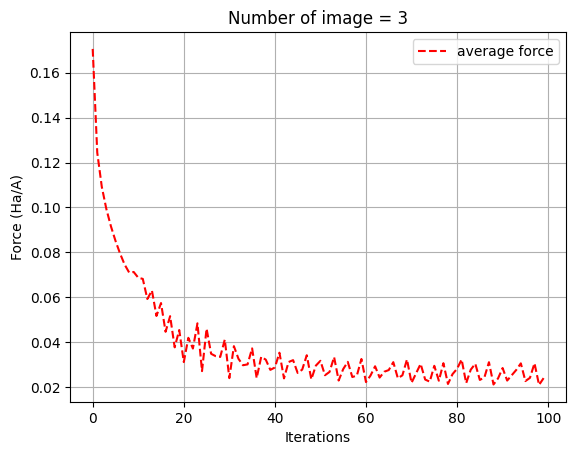

In [5]:
from matplotlib import pyplot as plt

plt.grid()

plt.plot(list(range(len(ave_force_adam_depth2_1))), ave_force_adam_depth2_1, color='r', linestyle='--', label='average force')


plt.xlabel('Iterations')

plt.ylabel('Force (Ha/A)')  

plt.legend()
plt.title(f'Number of image = 3')
plt.show()

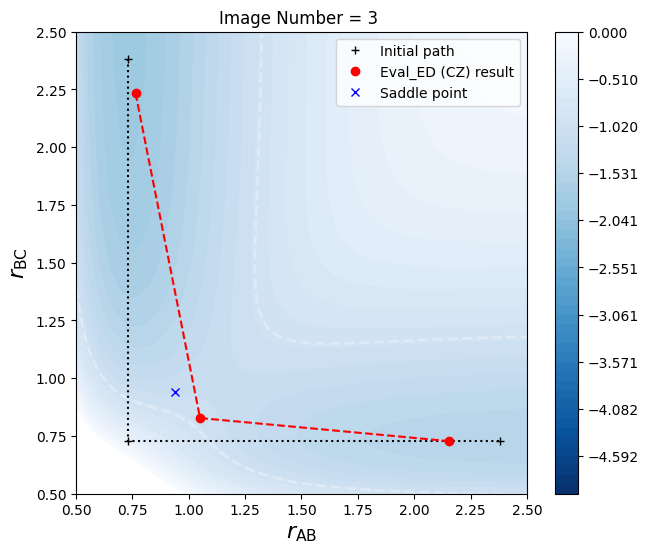

In [6]:
# Get optimized key length after training
result_key_len_array_1, init_ket_list_1 = NEB.coor_to_key(coor_adam_depth2_1)

# Use the classical method to calculate the ground state energy of each reaction coordinate
rAB, rBC = np.meshgrid(np.arange(0.2, 4.1, 0.05), np.arange(0.2, 4.1, 0.05))

l = rAB.flatten().shape[0]
LEPS = np.zeros(l)
for i in np.arange(l):
    LEPS[i] = NEB.V_LEPS(rAB.flatten()[i], rBC.flatten()[i])
LEPS = LEPS.reshape(rAB.shape)

rAB_II, x = np.meshgrid(np.arange(0.2, 4.1, 0.05), np.arange(-2, 1.5, 0.05))
l = rAB_II.flatten().shape[0]
LEPS_II = np.zeros(l)
for i in np.arange(l):
    LEPS_II[i] = NEB.V_LEPS_II(rAB_II.flatten()[i], x.flatten()[i])
LEPS_II = LEPS_II.reshape(rAB_II.shape)

fig = plt.figure(figsize = (16, 6))

ax = fig.add_subplot(1, 2, 1)
C = plt.contourf(rAB, rBC, LEPS, levels = np.linspace(-5.0, 0.0, 50), cmap="Blues_r")
plt.colorbar()
ax.contour(rAB, rBC, LEPS, levels = np.linspace(-5.0, 0.0, 6), colors='white', alpha = 0.3, linewidths = 2)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(0.5, 2.5)
ax.set_xlabel('$r_\mathrm{AB}$', fontsize = 16)
ax.set_ylabel('$r_\mathrm{BC}$', fontsize = 16)


x1 = np.array(result_key_len_array_1[:,0])
y1 = np.array(result_key_len_array_1[:,1])


x2 = np.array(init_ket_list_1[:,0])
y2 = np.array(init_ket_list_1[:,1])



ax.plot(x2,y2, '+', color='k',  label='Initial path')
ax.plot(x2,y2,color='k',linestyle=':')

ax.plot(x1,y1,'o', color='r',  label='Eval_ED (CZ) result')
ax.plot(x1,y1,'r',linestyle='--')

ax.plot([0.94], [0.94], 'x', color='b',  label='Saddle point')
ax.set_title(f'Image Number = 3 ')

ax.legend(loc='upper right')

### Conclusion

We reproduced the proposed quantum algorithm in the paper. We have reproduced three of the images, and the results are as follows.

As shown in the figure, we have well reduced the calculation results and obtained the results of atomic bond length and force convergence that are similar to the results of the paper, which showed as Figure.

There are still some deficiencies:
1. The article uses the central difference method, which consumes a lot of time. We haven't done much expansion.
2. Due to time constraints, only one of the results was reproduced.

<div align=left><img src="result.png" width=800 length=800></div>


[1] Kanno S. Quantum algorithm for a chemical reaction path optimization by using a variational quantum algorithm and a reaction path generation[J]. arXiv preprint arXiv:2009.06803v2, 2022.